In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# calculate du^ n / dt^n for arbitrary n and use this to create a loss term
def higher_order_loss_term(weight, outputs, t, norm_term, forcing_funct):
    
    # compute derivative of outputs with respect to inputs 
    deriv_to_t = torch.autograd.grad(outputs, t, grad_outputs=torch.ones_like(outputs), 
                                 create_graph=True)[0]
          
    # additional loss term
    loss_term = norm_term * weight * torch.mean((deriv_to_t + forcing_funct) ** 2)
    loss_term = weight * torch.mean((deriv_to_t + forcing_funct) ** 2)
    
    return loss_term, deriv_to_t

# build the loss function
def loss(t, As, lambda_vals, model, loss_term_weights):
            
    # create the trial solution
    u1_t = lambda t: model(t)[0][:, 0].unsqueeze(dim=1)
    u2_t = lambda t: model(t)[0][:, 1].unsqueeze(dim=1)
    
    # normalize loss and use it to compute the normalization factor
    norm_term1, norm_term2 = 1 / As[0] ** 2, 1 / As[1] ** 2
    
    # initialize all loss terms in case they do not need to be computed
    L_D, L_DD, L_DDD, L_DDDD = [torch.tensor([[0.]])] * 4
    
    # loss results
    loss_dict = {}
    
    # define f (aka forcing function) for each differential equation
    f1 = lambda t, u: lambda_vals[0] * u 
    f2 = lambda t, u: lambda_vals[1] * u 
    
    # compute u1(t) and u2(t)
    outputs1, outputs2 = u1_t(t), u2_t(t)
        
    # initial value loss terms
    initial_val_loss1 = (As[0] - u1_t(torch.tensor([[0]], dtype=torch.float32)))**2
    initial_val_loss2 = (As[1] - u2_t(torch.tensor([[0]], dtype=torch.float32)))**2
    initial_val_loss = initial_val_loss1 + initial_val_loss2

    # computes residual (function call also returns du / dt as u_t_x)
    L_D1, u_t_x1 = higher_order_loss_term(loss_term_weights[0], outputs1, t, norm_term1, f1(t, outputs2))
    L_D2, u_t_x2 = higher_order_loss_term(loss_term_weights[0], outputs2, t, norm_term2, f2(t, outputs1))
    L_D = L_D1 + L_D2     
    
    if loss_term_weights[1] or loss_term_weights[2] or loss_term_weights[3]:
        # define f' (derivative of f)
        f_t = lambda_val * u_t_x
        # first derivative of residual (function call also returns d^2u / dt^2 as u_tt_x)
        L_DD, u_tt_x = higher_order_loss_term(loss_term_weights[1], u_t_x, t, norm_term, f_t)

    if loss_term_weights[2] or loss_term_weights[3]:
        # define f'' (derivative of f')
        f_tt = lambda_val * u_tt_x
        # second derivative of residual (function call also returns d^3u / dt^3 as u_ttt_x)
        L_DDD, u_ttt_x = higher_order_loss_term(loss_term_weights[2], u_tt_x, t, norm_term, f_tt)
        
    if loss_term_weights[3]:
        # define f''' (derivative of f'')
        f_ttt = lambda_val * u_ttt_x
        # third derivative of residual (function call also returns d^4u / dt^4 as u_tttt_x)
        L_DDDD, u_tttt_x = higher_order_loss_term(loss_term_weights[3], u_ttt_x, t, norm_term, f_ttt)
        
    # total loss 
    L_total = L_D + L_DD + L_DDD + L_DDDD + initial_val_loss
        
    loss_dict['L_D'] = L_D
    loss_dict['L_DD'] = L_DD
    loss_dict['L_DDD'] = L_DDD
    loss_dict['L_DDDD'] = L_DDDD
    loss_dict['L_total'] = L_total

    return loss_dict


In [3]:
# class to build the network 
class BuildNetwork(nn.Module):
    def __init__(self, input_size, h_size1, h_size2, h_size3, output_size):
        super(BuildNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, h_size1)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(h_size1, h_size2)
        self.l3 = nn.Linear(h_size2, h_size3)
        self.output = nn.Linear(h_size3, output_size) # bias = True
        
    def forward(self, x):
        result = self.l1(x)
        result = self.tanh(result)
        result = self.l2(result)
        result = self.tanh(result)
        result = self.l3(result)
        h = self.tanh(result)
        result = self.output(h)
        
        return result, h

In [4]:
# train and evaluate the model
def run_model(iterations, min_x, max_x, A_vals, lambda_vals, loss_term_weights):
    
    assert sum(loss_term_weights) != 0, "ERROR: Invalid Loss Function"
    
    for idx, num in enumerate(loss_term_weights[:-1]):
        next_num = loss_term_weights[idx + 1]
        assert next_num <= num, 'ERROR: Invalid Loss Function'
      
    # build the neural net model
    model = BuildNetwork(1, 64, 64, 128, 2)
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    
    # store loss and mse values
    loss_history = defaultdict(list)
    MSEs = []
    
    start_time = time.time()
    
    # starting initial value for transfer learning
    curr_A_indx = 0
    A = A_vals[curr_A_indx]
    print(f"Initial Conditions: {A}")
    # run the training loop
    for i in range(iterations):
        
        if i % 2000 == 0 and i != 0: 
            curr_A_indx += 1 
            A = A_vals[curr_A_indx]
            print(f"Initial Conditions: {A}")
        
        # every batch, randomly sample from min and max range
        x = torch.arange(min_x, max_x, 0.001, requires_grad=True)
        x = x[rng.integers(low=0, high=len(x), size=500)]
        x = x.reshape(-1, 1)

        # forward: compute loss
        curr_loss = loss(x, A, lambda_vals, model, loss_term_weights)
        
        # store individual loss terms for plotting
        loss_history['LD_losses'].append(curr_loss['L_D'].item())
        loss_history['LDD_losses'].append(curr_loss['L_DD'].item())
        loss_history['LDDD_losses'].append(curr_loss['L_DDD'].item())
        loss_history['LDDDD_losses'].append(curr_loss['L_DDDD'].item())
        loss_history['Ltotal_losses'].append(curr_loss['L_total'].item())
            
        # backward: backpropagation
        curr_loss['L_total'].backward()
        
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
        
        # learning rate update
#         scheduler.step()
        
        # compute the mse
        with torch.no_grad():
            e_term1, e_term2 = np.exp(-1.1 * x), np.exp(2.2 * x)
            true_sol1 = (0.5 * A[0] * e_term1 * (e_term2 + 1) - (0.5 * A[1] * e_term1 * (e_term2 - 1))).numpy()
            network_sol1 = model(x)[0][:, 0].unsqueeze(dim=1).numpy()
            true_sol2 = (0.5 * A[1] * e_term1 * (e_term2 + 1) - (0.5 * A[0] * e_term1 * (e_term2 - 1))).numpy()
            network_sol2 = model(x)[0][:, 1].unsqueeze(dim=1).numpy()
            
        current_mse = np.mean((true_sol1 - network_sol1) ** 2) + np.mean((true_sol2 - network_sol2) ** 2)
        MSEs.append(current_mse)
   
    end_time = time.time()
    total_time = end_time - start_time
    
    print(f"Model Training Complete in{total_time: .3f} seconds")
    
    return loss_history, model, total_time, MSEs

In [5]:
# function to plot the neural network vs exact solution
def plot_solution(min_x, max_x, As, lambda_vals, trained_model, axis):
    
    u1_t = lambda t: trained_model(t)[0][:, 0]
    u2_t = lambda t: trained_model(t)[0][:, 1]
    
    # plot the solution accuracies
    xx = np.linspace(min_x, max_x, 200)[:, None]

    with torch.no_grad():
        yy1 = u1_t(torch.Tensor(xx)).numpy()
        yy2 = u2_t(torch.Tensor(xx)).numpy()

    e_term1, e_term2 = np.exp(-1.1 * xx), np.exp(2.2 * xx)
    yt1 = (0.5 * As[0] * e_term1 * (e_term2 + 1) - (0.5 * As[1] * e_term1 * (e_term2 - 1)))
    yt2 = (0.5 * As[1] * e_term1 * (e_term2 + 1) - (0.5 * As[0] * e_term1 * (e_term2 - 1)))

    axis.plot(xx, yt1, label='Actual Solution $u_1(t)$')
    axis.plot(xx, yt2, label='Actual Solution $u_2(t)$')
    axis.plot(xx, yy1, '--', label='Neural Network Solution $u_1(t)$')
    axis.plot(xx, yy2, '--', label='Neural Network Solution $u_2(t)$')
    axis.set_title("u(t) vs t for Actual and Approximation")
    axis.set_xlabel('$t$')
    axis.set_ylabel('$u(t)$')
    axis.legend(loc='best')
    
# function to plot the overall loss of the network solution
def plot_total_loss(iterations, train_losses, axis, loss_label):
    axis.plot(range(iterations), train_losses, label=loss_label)
    axis.set_yscale("log")
    axis.set_title("Total Loss vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Loss')
    axis.legend(loc='best')
    
# function to plot the MSEs
def plot_mse(iterations, mses, axis):
    axis.plot(range(iterations), mses, label='MSE')
    axis.set_yscale("log")
    axis.set_title("MSE vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('MSE')
    axis.legend(loc='best')
    
# wrapper function to plot the solution and the overall loss of the network solution
def plot_loss_mse_and_solution(min_x, max_x, As, lambda_vals, iterations, 
                               trained_model, train_losses, loss_label, mses):
    fig, axs = plt.subplots(1, 3,  tight_layout=True, figsize=(24, 8))
    
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=axs[0], loss_label=loss_label)
    plot_solution(min_x=min_x, max_x=max_x, As=As, lambda_vals=lambda_vals, 
                  trained_model=trained_model, axis=axs[1])
    plot_mse(iterations=iterations, mses=mses, axis=axs[2])
    
    plt.show()
    
# function to plot the loss terms for a given model
def plot_individual_loss_terms(iterations, loss_dictionary):
    
    plt.figure(figsize=(9, 9))
    for label, losses in loss_dictionary.items():
        plt.plot(range(iterations), losses, label=label)
        
    plt.yscale("log")
    plt.title("Loss Terms vs Iterations")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [6]:
# set-up differential equation parameters for network
min_x, max_x = 0, 2
A_vals = [[0.75, 0.25], [0.75, 0.25], [0.75, 0.25], [0.75, 0.25], [0.75, 0.25]]
lambda_vals = [1.1, 1.1]
iterations = 10000

# run model which has a loss of the MSE (i.e. no higher order terms)
loss_history_w1, trained_model_w1, time_w1, MSE_w1 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                              lambda_vals=lambda_vals, loss_term_weights=[1, 0, 0, 0])

if False:
    
    # run model which has a loss of the residual and the first derivative of the residual (i.e. one higher order term)
    loss_history_w2, trained_model_w2, time_w2, MSE_w2 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                                    lambda_vals=lambda_vals, loss_term_weights=[1, 1, 0, 0])


    # run model which has a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
    loss_history_w3, trained_model_w3, time_w3, MSE_w3 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                                    lambda_vals=lambda_vals, loss_term_weights=[1, 1, 1, 0])

    # run model which has a loss of the residual and the first three derivatives of the residual (i.e. three higher order terms)
    loss_history_w4, trained_model_w4, time_w4, MSE_w4 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                                    lambda_vals=lambda_vals, loss_term_weights=[1, 1, 1, 1])

Initial Conditions: [0.75, 0.25]
Initial Conditions: [0.75, 0.25]
Initial Conditions: [0.75, 0.25]
Initial Conditions: [0.75, 0.25]
Initial Conditions: [0.75, 0.25]
Model Training Complete in 52.963 seconds


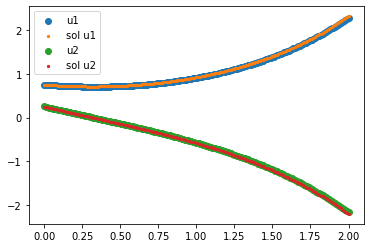

In [7]:
A = [0.75, 0.25]
xx = torch.Tensor(np.linspace(0, 2, 200)[:, None])
u_1 = trained_model_w1(xx)[0][:, 0].detach().numpy()
u_2 = trained_model_w1(xx)[0][:, 1].detach().numpy()

e_term1, e_term2 = np.exp(-1.1 * xx), np.exp(2.2 * xx)

yt1 = (0.5 * A[0] * e_term1 * (e_term2 + 1) - (0.5 * A[1] * e_term1 * (e_term2 - 1))).numpy()
yt2 = (0.5 * A[1] * e_term1 * (e_term2 + 1) - (0.5 * A[0] * e_term1 * (e_term2 - 1))).numpy()

plt.scatter(xx, u_1, label='u1')
plt.scatter(xx, yt1, label='sol u1', s=5)
plt.scatter(xx, u_2, label='u2')
plt.scatter(xx, yt2, label='sol u2', s=5)
plt.legend();


 Model 1: Loss = L_D


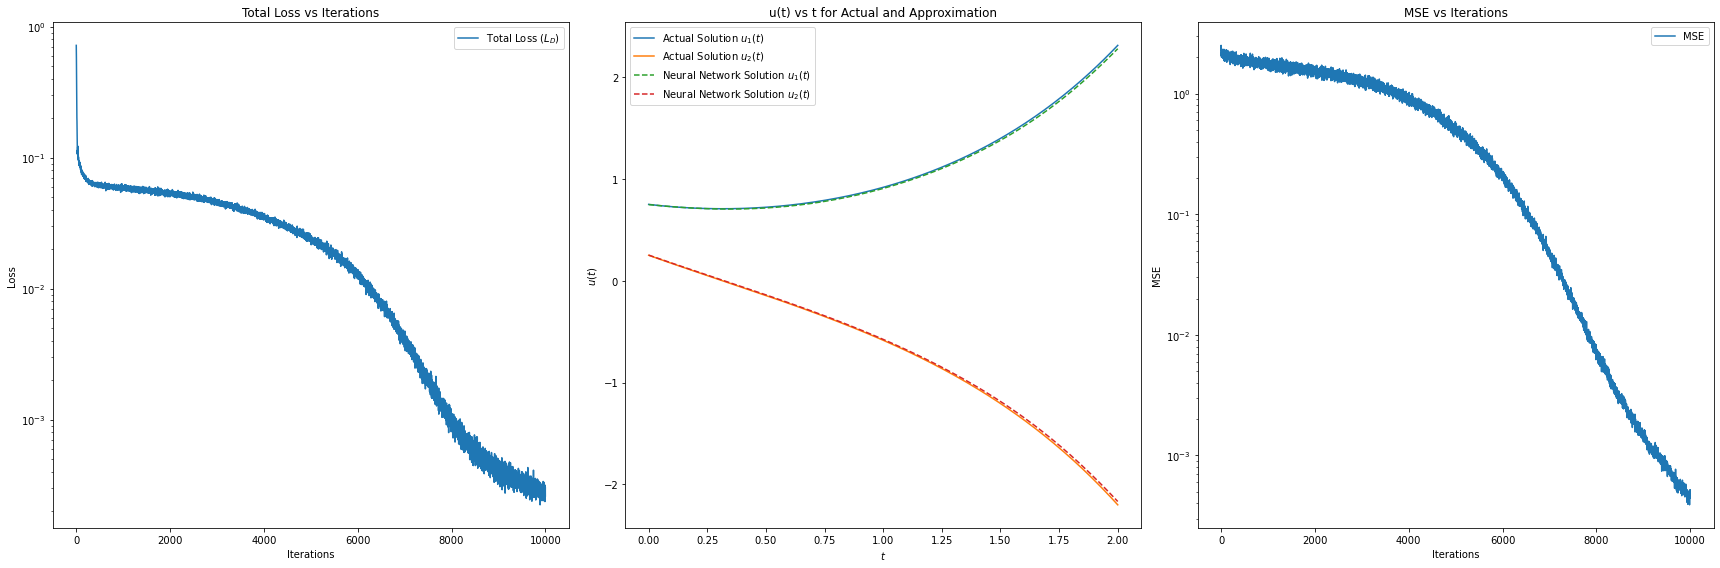

In [8]:
# plot overall loss and network solution for model which has a loss of the MSE (i.e. no higher order terms)
print("\n Model 1: Loss = L_D")
plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, As=A_vals[3], lambda_vals=lambda_vals, 
                       iterations=iterations, trained_model=trained_model_w1, 
                       train_losses=loss_history_w1['Ltotal_losses'], 
                       loss_label='Total Loss ($L_D$)', mses=MSE_w1)

if False:
    
    # plot overall loss and network solution for model which has a loss of the residual and the first derivative of the residual (i.e. one higher order term)
    print("\n Model 2: Loss = L_D + L_DD")
    plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A_vals[3], lambda_val=lambda_val, 
                           iterations=iterations, trained_model=trained_model_w2, 
                           train_losses=loss_history_w2['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D + L_{DD}$)', mses=MSE_w2)


    # plot overall loss and network solution for model which has a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
    print("\n Model 3: Loss = L_D + L_DD + L_DDD")
    plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A_vals[3], lambda_val=lambda_val, 
                           iterations=iterations, trained_model=trained_model_w3, 
                           train_losses=loss_history_w3['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D + L_{DD} + L_{DDD}$)', mses=MSE_w3)

    # plot overall loss and network solution for model which has a loss of the residual and the first three derivatives of the residual (i.e. three higher order terms)
    print("\n Model 4: Loss = L_D + L_DD + L_DDD + L_DDDD")
    plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A_vals[3], lambda_val=lambda_val, 
                           iterations=iterations, trained_model=trained_model_w4, 
                           train_losses=loss_history_w4['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D + L_{DD} + L_{DDD} + L_{DDDD}$)', mses=MSE_w4)

In [9]:
if False:
    
    # plot of differential equation residual (L_D) for each updated model
    plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D$)' : loss_history_w1['LD_losses'],
                                            '$L_D$ (loss = $L_D + L_{DD}$)' : loss_history_w2['LD_losses'],
                                            '$L_D$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LD_losses'],
                                            '$L_D$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LD_losses']})

    # plot of L_D and L_DD when using a loss of the residual and the first derivative of the residual (i.e. one higher order term)
    plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD}$)' : loss_history_w2['LD_losses'], 
                                            '$L_{DD}$ (loss = $L_D + L_{DD}$)' : loss_history_w2['LDD_losses']})

    # plot of L_D, L_DD, and L_DDD when using a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
    plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LD_losses'], 
                                            '$L_{DD}$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LDD_losses'],
                                            '$L_{DDD}$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LDDD_losses']})

    # plot of L_D, L_DD, L_DDD, and L_DDDD when using a loss of the residual and the first three derivatives of the residual (i.e. three higher order terms)
    plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LD_losses'], 
                                            '$L_{DD}$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LDD_losses'],
                                            '$L_{DDD}$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LDDD_losses'],
                                            '$L_{DDDD}$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LDDDD_losses']})
